In [5]:
import cPickle
import pylab
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
import pandas as pd
%matplotlib inline

In [6]:
with open("mr3_pa2_s16_results.pickle", "r") as f:
    data = cPickle.load(f)

In [7]:
data.keys()

['respSel',
 'corrLive',
 'scan_freq',
 'resp',
 'rmsLive',
 'sel',
 'corrDark',
 'kurtLive',
 'normDark',
 'live',
 'stable',
 'skewLive',
 'normLive',
 'darkRatioLive',
 'MFELive',
 'dark',
 'ff',
 'jumpDark',
 'gainDark',
 'name',
 'gainLive',
 'DELive',
 'cal',
 'rmsDark',
 'jumpLive',
 'DEDark']

We have looked at the basis statistics, now let's implement some simple statistical manipulations. 

## Grouping
I would like to group the detectors based on the selected or not selected

In [8]:
# Define the tags that we are interested in
tags = ['corrLive', 'rmsLive', 'kurtLive', 'skewLive', 'normLive', \
        'darkRatioLive', 'MFELive', 'gainLive', 'DELive', 'jumpLive']

In [9]:
selected = data['sel']==1
deselected = data['sel']==0

In [10]:
selected_data = []
deselected_data = []
for tag in tags:
    selected_data.append(data[tag][selected])
    deselected_data.append(data[tag][deselected])
    

In [11]:
good_data = np.vstack(selected_data).T
bad_data = np.vstack(deselected_data).T

In [12]:
print good_data.shape
print bad_data.shape

(7488229, 10)
(6273563, 10)


In [13]:
good_data_df = pd.DataFrame(good_data)
good_data_df.columns = tags
bad_data_df = pd.DataFrame(bad_data)
bad_data_df.columns = tags

In [14]:
print "Good Data:"
print good_data_df.describe()
print 
print "Bad Data:"
print bad_data_df.describe()

Good Data:
           corrLive       rmsLive      kurtLive      skewLive      normLive  \
count  7.488229e+06  7.488229e+06  7.488229e+06  7.488229e+06  7.488229e+06   
mean   9.939555e-01  1.442978e+03  1.578835e+00 -4.447728e-04  5.338309e+06   
std    7.109245e-03  7.142639e+02  2.088896e+00  1.075172e+00  6.226124e+06   
min    9.500005e-01  8.437833e+00 -4.997394e+00 -4.998052e+00  1.579575e+04   
25%    9.926150e-01  9.961767e+02  3.349300e-01 -7.149229e-01  1.495942e+06   
50%    9.963938e-01  1.299896e+03  1.227379e+00 -3.137847e-04  3.315818e+06   
75%    9.982863e-01  1.705523e+03  2.291919e+00  7.145216e-01  6.884080e+06   
max    9.999995e-01  2.374234e+04  1.499987e+01  4.999719e+00  4.378115e+08   

       darkRatioLive       MFELive      gainLive        DELive      jumpLive  
count   7.488229e+06  7.488229e+06  7.488229e+06  7.488229e+06  7.488229e+06  
mean    8.299198e-01  8.198705e+03  9.800994e-01  1.505025e+05  2.376738e-03  
std     1.171682e-01  9.710919e+03  3.48

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e76904d0>,
      dtype=object)

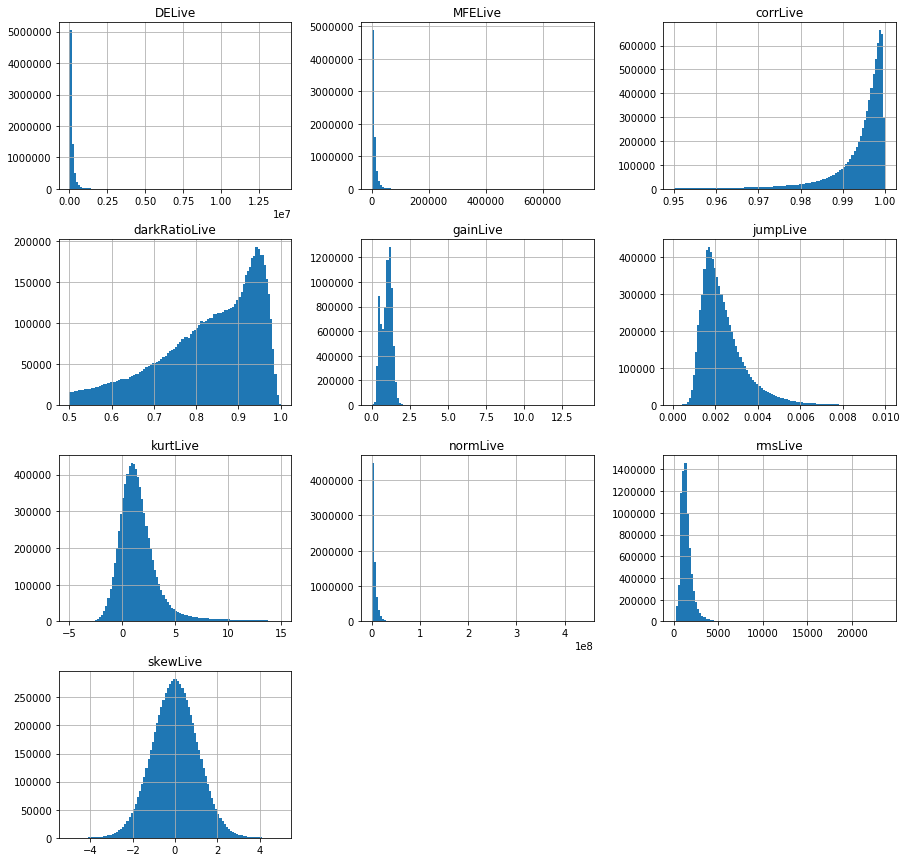

In [15]:
good_data_df.hist(figsize=(15,15),bins=100)

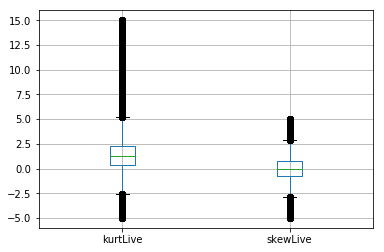

In [16]:
good_data_df.boxplot(column=['kurtLive', 'skewLive'])

Now we have grouped the detector data according to whether they are selected or not. For each detector, there are 10 features (attribute). One thing to notice is that for bad data, there are about 3e4 data points in gainLive that's nan. We need to clean that up first. 

In [17]:
bad_data_df = bad_data_df.dropna(axis=0, how="any")

In [18]:
good_data = good_data_df.as_matrix()
bad_data = bad_data_df.as_matrix()

# PCA
We are going to perform a principle component analysis on the ten properties to see if there is any chance of dimension reduction. Let's look at the good data first.
## Normalize
Let's normalize the data first so that it's easier to compare. 

In [19]:
std_scaler = preprocessing.StandardScaler().fit(good_data)

In [20]:
good_data_trans = std_scaler.transform(good_data)
bad_data_trans = std_scaler.transform(bad_data)

## PCA

In [21]:
from sklearn.decomposition import PCA

In [22]:
sklearn_pca = PCA(n_components=None)
sklearn_pca.fit(good_data_trans)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[0.36402575 0.15918187 0.10000026 0.09538368 0.08190422 0.06959188
 0.05991982 0.03186045 0.02251621 0.01561584]


<Container object of 10 artists>

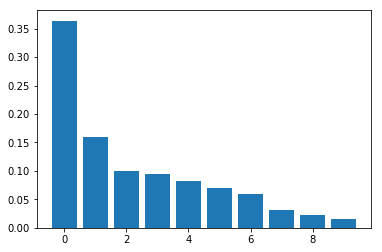

In [23]:
print sklearn_pca.explained_variance_ratio_
plt.bar(range(10),sklearn_pca.explained_variance_ratio_, )

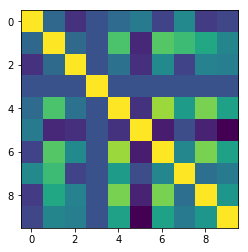

In [24]:
plt.imshow(sklearn_pca.get_covariance())

In [25]:
good_data_pca = sklearn_pca.transform(good_data_trans)
bad_data_pca = sklearn_pca.transform(bad_data_trans)

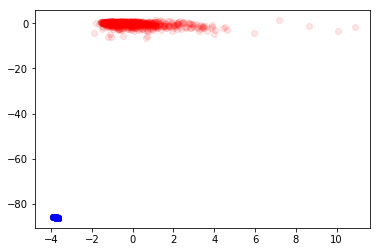

In [26]:
plt.scatter(good_data_pca[:1000,0], good_data_pca[:1000,1],alpha=0.1, color='r')
plt.scatter(bad_data_pca[:1000,0], bad_data_pca[:1000,1],alpha=0.1, color='b')

The two distributions looks clearly distinguishable. However, this may be because we are taking data in order, and maybe the first few TOD isn't representative enough. Let's apply random sampling in both groups and repeat the same procedures.

## Random Sampling

In [27]:
n_samples = 10000
good_data = good_data_df.sample(n=n_samples).as_matrix()
bad_data = bad_data_df.sample(n=n_samples).as_matrix()

In [28]:
good_data_trans = std_scaler.transform(good_data)
bad_data_trans = std_scaler.transform(bad_data)
good_data_pca = sklearn_pca.transform(good_data_trans)
bad_data_pca = sklearn_pca.transform(bad_data_trans)

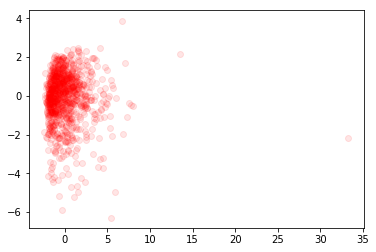

In [29]:
plt.scatter(good_data_pca[:1000,0], good_data_pca[:1000,1],alpha=0.1, color='r')

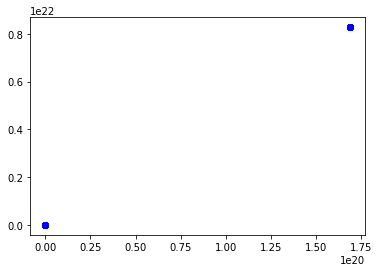

In [30]:
plt.scatter(bad_data_pca[:,0], bad_data_pca[:,1],alpha=0.1, color='b')

We see that it is polluted by overflow, let's try to clean that up by restricting the range of bad_data

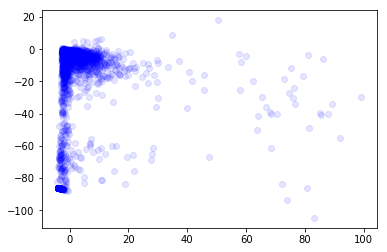

In [31]:
_data_x = bad_data_pca[:,0]
_data_y = bad_data_pca[:,1]
sel = (_data_x < 100) & (_data_y < 100)
plt.scatter(_data_x[sel], _data_y[sel],alpha=0.1, color='b')

This looks much better, let me plot it together with the good data

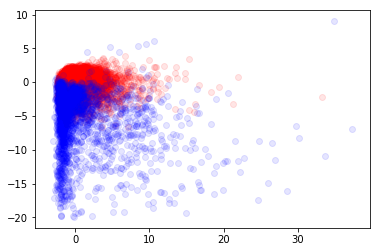

In [32]:
plt.figure()
plt.scatter(good_data_pca[:,0], good_data_pca[:,1],alpha=0.1, color='r')
sel = (_data_x > -50) & (_data_x < 40) & (_data_y > -20) &(_data_y < 100)
plt.scatter(_data_x[sel], _data_y[sel],alpha=0.1, color='b')

There is already some discriminating power from the first variable in the pca transformed basis. Let's look at one additional dimension.

In [38]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib nbagg

<IPython.core.display.Javascript object>


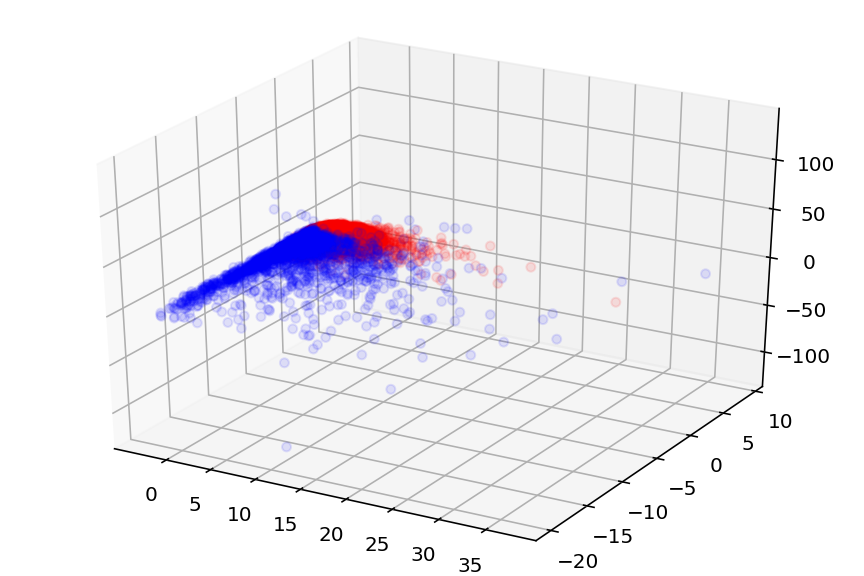

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(good_data_pca[:,0], good_data_pca[:,1],good_data_pca[:,2], alpha=0.1, color='r')
sel = (_data_x > -50) & (_data_x < 40) & (_data_y > -20) &(_data_y < 100)
_data_z = bad_data_pca[:,2]
ax.scatter(_data_x[sel], _data_y[sel], _data_z[sel] ,alpha=0.1, color='b')